# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 5
# Logistic Regression and PCA 

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A): AC209A

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
%matplotlib inline



D:\ProgramData\Anaconda3\envs\py36\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Cancer Classification from Gene Expressions

In this homework assignment, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The data set is provided in the file `dataset_hw5.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with 0 indicating the ALL class and 1 indicating the AML class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following parts, we will use logistic regression to build a classification model for this data set. We will also use principal components analysis (PCA) to visualize the data and to reduce its dimensions. 



## Part (a): Data Exploration

1. First step is to  split  the observations into an approximate 50-50 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits).

2. Take a peak at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.

3. Notice that the results training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?

4. A convenient tool to visualize the gene expression data is a heat map. Arrange the rows of the training set so that the 'AML' rows are grouped together and the 'ALL' rows are together. Generate a heat map of the data with expression values from the following genes: 
`D49818_at`, `M23161_at`, `hum_alu_at`, `AFFX-PheX-5_at`, `M15990_at`. By observing the heat map, comment on which of these genes are useful in discriminating between the two classes.

5. We can also visualize this data set in two dimensions using PCA. Find the top two principal components for the gene expression data. Generate a scatter plot using these principal components, highlighting the AML and ALL points in different colors. How well do the top two principal components discriminate between the two classes?



In [2]:
np.random.seed(9001)
df = pd.read_csv('dataset_hw5.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

In [3]:
data_train.head()

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,0,-214,-153,-58,88,-295,-558,199,-176,252,...,185,511,-125,389,-37,793,329,36,191,-37
5,0,-67,-93,84,25,-179,-323,-135,-127,-2,...,48,224,60,194,-10,291,41,8,-2,-80
9,0,-476,-213,-18,301,-403,-394,-42,-144,98,...,241,1214,127,255,50,1701,1108,61,525,-83
12,0,17,-229,79,218,-262,-404,325,-201,6,...,225,1020,-109,209,-51,1434,255,53,545,-16
13,0,-144,-199,-157,132,-151,-347,-118,-24,126,...,103,595,-12,36,26,208,113,-8,22,-22


In [4]:
X_train = data_train.drop("Cancer_type", axis=1).reset_index(drop=True)
y_train = data_train["Cancer_type"].reset_index(drop=True)

X_test = data_test.drop("Cancer_type", axis=1).reset_index(drop=True)
y_test = data_test["Cancer_type"].reset_index(drop=True)

X_cols = X_train.columns

In [5]:
scaler = MinMaxScaler((0, 1))

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_cols)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_cols)

In [6]:
AML_rows = X_train.loc[(y_train==1).values] #AML
ALL_rows = X_train.loc[(y_train==0).values] #ALL


In [7]:
heatmap_cols = ["D49818_at", "M23161_at", "hum_alu_at", "AFFX-PheX-5_at", "M15990_at"]

In [8]:
AML_rows[heatmap_cols].mean(axis=0)


D49818_at         0.573192
M23161_at         0.255162
hum_alu_at        0.530630
AFFX-PheX-5_at    0.629310
M15990_at         0.231240
dtype: float64

In [9]:
ALL_rows[heatmap_cols].mean(axis=0)

D49818_at         0.504676
M23161_at         0.374248
hum_alu_at        0.465162
AFFX-PheX-5_at    0.553640
M15990_at         0.266351
dtype: float64

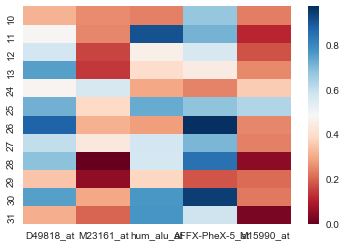

In [10]:
sns.heatmap(AML_rows[heatmap_cols], cmap="RdBu")

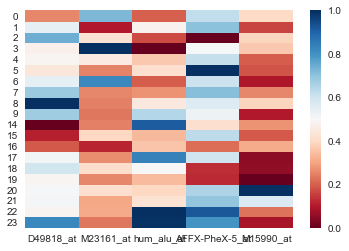

In [11]:
sns.heatmap(ALL_rows[heatmap_cols], cmap="RdBu")

In [12]:
X_train.describe()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,...,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,0.624055,0.554310,0.574792,0.566406,0.419684,0.593750,0.455662,0.583820,0.542561,0.540228,...,0.378586,0.392435,0.636270,0.288934,0.637384,0.358404,0.300761,0.722114,0.193695,0.561800
std,0.202594,0.255539,0.198218,0.298191,0.205918,0.226106,0.220498,0.212797,0.234644,0.217127,...,0.239203,0.239999,0.218186,0.191286,0.214031,0.232741,0.225406,0.192814,0.231173,0.182029
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.528915,0.386207,0.460873,0.333097,0.257704,0.455305,0.291638,0.457944,0.352668,0.395665,...,0.186066,0.226173,0.508197,0.193369,0.537037,0.196229,0.122391,0.638889,0.078367,0.456157
50%,0.642349,0.563793,0.577562,0.559659,0.425270,0.598837,0.452265,0.620327,0.558005,0.535282,...,0.378689,0.360704,0.685012,0.233301,0.622222,0.314657,0.279565,0.741319,0.099325,0.563433
75%,0.738434,0.781034,0.660665,0.803267,0.516179,0.726381,0.570906,0.731308,0.726798,0.669607,...,0.529508,0.481488,0.800937,0.358180,0.790741,0.503983,0.380870,0.821181,0.222487,0.695896
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
pca_model = PCA(n_components=2)
pca_model.fit_transform(X_train)
X_train_PCA = pd.DataFrame(pca_model.fit_transform(X_train),\
                          columns=["pc1","pc2"])
X_train_PCA["target"] = y_train

In [14]:
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

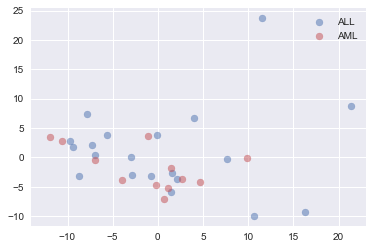

In [15]:
colors = [c0, c2]
for label, color, class_ in zip(y_train.unique(), colors, ["ALL", "AML"]):
    mask = y_train==label
    plt.scatter(X_train_PCA.loc[mask,'pc1'], X_train_PCA.loc[mask,'pc2'], c=color, label=class_, alpha=0.5)
plt.legend()

In [16]:
pca_model.explained_variance_ratio_

array([ 0.17206147,  0.10732536])

## Part (b): Linear Regression vs. Logistic Regression

Begin by analyzing the differences between using linear regression and logistic regression for classification. For this part, you shall work with a single gene predictor: `D29963_at`.

1. Fit a simple linear regression model to the training set using the single gene predictor `D29963_at`. We could interpret the scores predicted by regression model interpreted for a patient as an estimate of the probability that the patient has the `ALL` type cancer (class 1). Is there a problem with this interpretation?

2. The fitted linear regression model can be converted to a classification model (i.e. a model that predicts one of two binary labels 0 or 1) by classifying patients with predicted score greater than 0.5 into the `ALL` type (class 1), and the others into the `AML` type (class 0). Evaluate the classification accuracy (1 - misclassification rate) of the obtained classification model on both the training and test sets.

3. Next, fit a simple logistic regression model to the training set. How does the training and test calssification accuracy of this model compare with the linear regression model?  Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order not to regularize (use 'C=100000').

4. Plot the quantitative output from linear regression model and the probabilistic output from the logistic regression model (on the training set points) as a function of the gene predictor. Also, display the true binary response for the training set points in the same plot.
Based on these plots, does one of the models appear better suited for binary classification than the other? Explain.



In [17]:
lm = LinearRegression(fit_intercept=True)

In [18]:
lm.fit(X_train.loc[:,["D29963_at",]], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [19]:
y_hat = lm.predict(X_train.loc[:,["D29963_at",]])

In [20]:

lm.score(y_train.values[:,None], y_hat[:,None])

-4.1778847300616491

In [21]:
ols_model = OLS(y_train, sm.add_constant(X_train["D29963_at"]))
ols_results = ols_model.fit()
print(ols_results.summary())

y_train_pred = ols_results.predict(sm.add_constant(X_train["D29963_at"]))

y_train_pred_type = y_train_pred.apply(lambda x: 1 if x > 0.5 else 0)

1 - (y_train_pred_type != y_train).mean()

                            OLS Regression Results                            
Dep. Variable:            Cancer_type   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     3.346
Date:                Wed, 18 Oct 2017   Prob (F-statistic):             0.0773
Time:                        21:48:11   Log-Likelihood:                -20.501
No. Observations:                  32   AIC:                             45.00
Df Residuals:                      30   BIC:                             47.93
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1313      0.157      0.834      0.4

0.71875

In [22]:
y_test_pred = ols_results.predict(sm.add_constant(X_test["D29963_at"]))

y_test_pred_type = y_test_pred.apply(lambda x: 1 if x > 0.5 else 0)

1 - (y_test_pred_type != y_test).mean()

0.85365853658536583

In [23]:
lg_model = LogisticRegression(C=100000).\
fit(X_train["D29963_at"].values.reshape(-1, 1), y_train)


In [24]:
lg_model.score(X_train["D29963_at"].values.reshape(-1, 1), y_train)

0.71875

In [25]:
lg_model.score(X_test["D29963_at"].values.reshape(-1, 1), y_test)

0.82926829268292679

In [26]:
X_train_sorted = np.sort(X_train["D29963_at"].values).reshape(-1, 1)
y_train_lg_prob = lg_model.predict_proba\
(X_train_sorted)[:,1]

In [27]:
beta0 = lg_model.intercept_[0]
beta1 = lg_model.coef_[0][0]

In [28]:
x_lg = np.linspace(-0.25, 1.25, 1000)
y_lg = np.exp(beta0+beta1*x_lg)/(1+np.exp(beta0+beta1*x_lg))



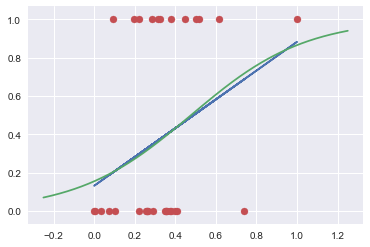

In [29]:
ax = plt.subplot()
ax.plot(X_train["D29963_at"].values, y_train_pred, c=c0)
ax.plot(x_lg, y_lg, c=c1)
ax.scatter(X_train["D29963_at"].values, y_train, c=c2)

## Part (c): Multiple Logistic Regression

1. Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in Part (b) with a single gene (on both the training and test sets)?  

2. "Use the `visualize_prob` from `HW5_functions.py` to visualize the probabilties predicted by the fitted multiple logistic regression model on both the training and test data sets. The function creates a visualization that places the data points on a vertical line based on the predicted probabilities, with the `ALL` and `AML` classes shown in different colors, and with the 0.5 threshold highlighted using a dotted horizontal line.  Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?"

In [30]:
# starter code
from HW5_functions import visualize_prob

In [31]:
def visualize_prob(model, x, y, ax):

    # Use the model to predict probabilities for
    y_pred = model.predict_proba(x)
    
    
    # Separate the predictions on the label 1 and label 0 points
    ypos = y_pred[y==1]
    yneg = y_pred[y==0]
    
    # Count the number of label 1 and label 0 points
    npos = ypos.shape[0]
    nneg = yneg.shape[0]
    
    # Plot the probabilities on a vertical line at x = 0, 
    # with the positive points in blue and negative points in red
    ax.scatter(np.zeros((npos,1)), ypos[:,1], 'b', label = 'ALL', alpha=0.3)
    ax.scatter(np.zeros((nneg,1)), yneg[:,1], 'r', label = 'AML', alpha=0.3)
    
    # Line to mark prob 0.5
    ax.axhline(y = 0.5, color = 'k', linestyle = '--')
    
    # Add y-label and legend, do not display x-axis, set y-axis limit
    ax.set_ylabel('Probability of AML class')
    ax.legend(loc = 'best')
    ax.get_xaxis().set_visible(True)
    ax.set_ylim([0,1])

TypeError: ufunc 'sqrt' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

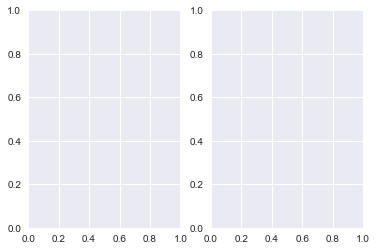

In [32]:
mlg_model = LogisticRegression(C=100000).\
fit(X_train.values, y_train)

mlg_model.score(X_train.values, y_train), \
mlg_model.score(X_test.values, y_test)

fig, (ax1, ax2) = plt.subplots(1, 2)
visualize_prob(mlg_model, X_train, y_train, ax1)
visualize_prob(mlg_model, X_test, y_test, ax2)

In [ ]:
ax = plt.subplot()

In [ ]:
ax = plt.subplot()

x = X_train

y=y_train

model = mlg_model

y_pred = model.predict_proba(x)
       
# Separate the predictions on the label 1 and label 0 points
ypos = y_pred[y==1]
yneg = y_pred[y==0]


# Count the number of label 1 and label 0 points
npos = ypos.shape[0]
nneg = yneg.shape[0]


# Plot the probabilities on a vertical line at x = 0, 
# with the positive points in blue and negative points in red

ax.scatter(np.zeros((npos,1))[:5], ypos[:,1][:5], label = 'ALL', alpha=0.3)


# Line to mark prob 0.5
ax.axhline(y = 0.5, color = 'k', linestyle = '--')

# Add y-label and legend, do not display x-axis, set y-axis limit
ax.set_ylabel('Probability of AML class')
ax.legend(loc = 'best')
ax.get_xaxis().set_visible(True)
ax.set_ylim([0.9,1.1])

In [ ]:
np.zeros((npos,1))[:5]

In [ ]:
ypos[:,1].reshape(-1, 1)

In [ ]:
np.zeros((npos,1))

## Part (d): Analyzing Significance of Coefficients

How many of the coefficients estimated by the multiple logistic regression in the previous problem are significantly different from zero at a *significance level of 95%*? 

Hint: To answer this question, use *bootstrapping* with 100 boostrap samples/iterations.  



In [ ]:
n_sims = 1000
fitting_coefs = np.zeros((n_sims, X_train.shape[1]+1))
for i in range(n_sims):
    index_bootstrap = np.random.choice(len(X_train), replace=True, size=100)
    X_train_bootstrap = X_train.iloc[index_bootstrap]
    y_train_bootstrap = y_train.iloc[index_bootstrap]
    mlg_model.fit(X_train_bootstrap, y_train_bootstrap),
    fitting_coefs[i:0] = mlg_model.intercept_[0]
    fitting_coefs[i,1:] = mlg_model.coef_[0]

coefs_quantiles = np.percentile(fitting_coefs, [2.5, 97.5], axis=0).T

1 - ((coefs_quantiles[:,0] < 0) & (coefs_quantiles[:,1] > 0)).mean()

## Part (e): Dimensionality Reduction using PCA

A reasonable approach to reduce the dimensionality of the data is to use PCA and fit a logistic regression model on the first set of principal components contributing to 90% of the variance in the predictors.

1. How do the classification accuracy values on both the training and tests sets compare with the models fitted in Parts (c) and (d)?  

2. Re-fit a logistic regression model using 5-fold cross-validation to choose the number of principal components, and comment on whether you get better test performance than the model fitted above (explain your observations). 

3. Use the code provided in Part (c) to visualize the probabilities predicted by the fitted models on both the training and test sets. How does the spread of probabilities in these plots compare to those for the models in Part (c) and (d)? 


---
 

In [ ]:
pca_model = PCA().fit(X_train)

In [ ]:
for i in range(X_train.shape[0]):
    if pca_model.explained_variance_ratio_[0:i+1].sum() > 0.9:
        pca_n = i+1
        break
print(pca_n)


In [ ]:
pca_model = PCA(n_components=pca_n).fit(X_train)

X_train_pca_24 = pca_model.transform(X_train)
X_test_pca_24 = pca_model.transform(X_test)

regression_model = LinearRegression(fit_intercept=True) 
regression_model.fit(X_train_pca_24, y_train)

R2_pca_train = regression_model.score(X_train_pca_24, y_train)
R2_pca_test = regression_model.score(X_test_pca_24, y_test)

R2_pca_train, R2_pca_test

# APCOMP209a - Homework Question

Suppose we want to conduct PCA on the model matrix $X \in \Re^{n×p}$, where the columns have been suitably set to zero mean. In this question, we consider the squared reconstruction error:

$$  \parallel XQ- XQ_m \parallel ^2 $$

for a suitable set of eigenvectors forming the matrix $Q_m$, as discussed below. Suppose that we conduct eigendecomposition of $X^T X$ and obtain eigenvalues $\lambda_1, \ldots , \lambda_p$ and principal components $Q$, i.e.

$$ X^T X = Q \Lambda Q ^T $$

(1) Suppose that the matrix norm is simply the squared dot product, namely

$$ \parallel A \parallel ^2 = A^T A $$

Then, express the reconstruction error as a sum of matrix products.

(2) Simplify your result from (1) based on properties of the matrices $Q$.

(3) Now let $Q_m$ be the matrix of the first $m < p$ eigenvectors, namely

$$ Q_m = (q_1, \ldots, q_m, 0, \ldots, 0) \in \Re^{p \times p} $$

Thus, $X Q_m$ is the PCA projection of the data into the space spanned by the first $m$ principal components. Express the products $Q^T_m Q$ and $Q^T Q_m$, again using properties of the eigenbasis $q_1, \ldots, q_p$.

(4) Use your results from (3) to finally fully simplify your expression from (2).

(5) Note that the result you obtain should still be a matrix, i.e. this does not define a proper norm on the space of matrices (since the value should be a scalar). Consequently, the true matrix norm is actually the trace of the
above result, namely

$$ \parallel A \parallel ^2  = {\rm trace} (A^T A) $$
Use your result from (4) and this new definition to find a simple expression
for the reconstruction error in terms of the eigenvalues.

(6) Interpret your result from (5). In light of your results, does our procedure for PCA (selecting the $m$ substantially larger eigenvalues) make sense? Why or why not?